### Урок 4. Классификация текста. Анализ тональности текста.#

### -- Автор: Шенк Евгений Станиславович

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
import textblob, string
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Тональность текста

#### NN

##### Загрузка данных

In [2]:
# url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
#                                     untar=True, cache_dir='.',
#                                     cache_subdir='')

# dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [3]:
dataset_dir = '.\\aclImdb'

#### Удаляем лишнее

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
remove_dir = os.path.join(train_dir, 'unsup')
#shutil.rmtree(remove_dir)

In [5]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [6]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [7]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [8]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


#### Обработка данных

In [9]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [10]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [11]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [12]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [13]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [14]:
"""# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))"""

'# retrieve a batch (of 32 reviews and labels) from the dataset\ntext_batch, label_batch = next(iter(raw_train_ds))\nfirst_review, first_label = text_batch[0], label_batch[0]\nprint("Review", first_review)\nprint("Label", raw_train_ds.class_names[first_label])\nprint("Vectorized review", vectorize_text(first_review, first_label))'

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Модель

In [16]:
embedding_dim = 16

In [17]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim,),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [19]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 15s 25ms/step - loss: 0.6614 - binary_accuracy: 0.6963 - val_loss: 0.6116 - val_binary_accuracy: 0.7730
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.5458 - binary_accuracy: 0.8029 - val_loss: 0.4956 - val_binary_accuracy: 0.8246
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4427 - binary_accuracy: 0.8465 - val_loss: 0.4183 - val_binary_accuracy: 0.8470
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3760 - binary_accuracy: 0.8669 - val_loss: 0.3722 - val_binary_accuracy: 0.8614
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3342 - binary_accuracy: 0.8803 - val_loss: 0.3438 - val_binary_accuracy: 0.8684
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3031 - binary_accuracy: 0.8893 - val_loss: 0.3248 - val_binary_accuracy: 0.8722
Epoch 7/10
625/625 [==============================] - 2s 4ms/s

In [20]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 37s 47ms/step - loss: 0.3098 - binary_accuracy: 0.8741 0s - loss: 0.3101 - binary_accuracy: 0.873
Loss:  0.3098389208316803
Accuracy:  0.8741199970245361


## Подготовка данных для tf-idf/count и word2vec

In [21]:
batch_size = 1
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [22]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [23]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [24]:
train_df = pd.DataFrame(raw_train_ds, columns=['text', 'lable'])
val_df = pd.DataFrame(raw_val_ds, columns=['text', 'lable'])
test_df = pd.DataFrame(raw_test_ds, columns=['text', 'lable'])

In [25]:
train_df['text'] = train_df['text'].apply(lambda x: x[0].numpy().decode())
train_df['lable'] = train_df['lable'].apply(lambda x: x.numpy()[0])

val_df['text'] = val_df['text'].apply(lambda x: x[0].numpy().decode())
val_df['lable'] = val_df['lable'].apply(lambda x: x.numpy()[0])

test_df['text'] = test_df['text'].apply(lambda x: x[0].numpy().decode())
test_df['lable'] = test_df['lable'].apply(lambda x: x.numpy()[0])

In [26]:
train_df.head(2)

,text,lable
0,The idea ia a very short film with a lot of in...,1
1,"Skippy from ""Family Ties"" plays Eddie, a wussy...",0


In [27]:
val_df.head(2)

,text,lable
0,"Unless I'm sadly mistaken, I rented A Nightmar...",0
1,This is my first movie review on IMDb. I was f...,0


In [28]:
test_df.head(2)

,text,lable
0,"As with all Haneke films, make your own decisi...",1
1,"Dr. Sayer(Philippe Leroy), a wealthy physician...",1


In [29]:
def removeApostropheFixed(review):
    phrase = re.sub(r"won't", "willnot", review)
    phrase = re.sub(r"can\'t", "cannot", review)
    phrase = re.sub(r"\snot", "not", review)
    phrase = re.sub(r"n\'t", "not", review)
    phrase = re.sub(r"\'re", " are", review)
    phrase = re.sub(r"\'s", " is", review)
    phrase = re.sub(r"\'d", " would", review)
    phrase = re.sub(r"\'ll", " will", review)
    phrase = re.sub(r"\'t", " not", review)
    phrase = re.sub(r"\'ve", " have", review)
    phrase = re.sub(r"\'m", " am", review)
    return phrase

def removeSpecialChars(review):
    phrase = re.sub(r"<br />", ' ', review)
    phrase = re.sub('[^a-zA-Z]', ' ', review)
    return phrase
    
def doCleaningFixed(review):
    review = removeApostropheFixed(review)
    review = removeSpecialChars(review) 
    review = review.lower()  
    review = review.split() #Tokenization
    lmtzr = WordNetLemmatizer()
    review = [lmtzr.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review = " ".join(review)    
    return review

In [30]:
train_df['text_clean'] = train_df['text'].apply(doCleaningFixed)
val_df['text_clean'] = val_df['text'].apply(doCleaningFixed)
test_df['text_clean'] = test_df['text'].apply(doCleaningFixed)

In [31]:
train_df['text_clean'].head(20)

0     idea ia short film lot information interesting...
1     skippy family tie play eddie wussy ametal nerd...
2     st watched dir steve purcell typical mary kate...
3     based comic book video game drawing year old b...
4     kid always used babysat always used rent film ...
5     mr perlman give standout performance usual sad...
6     movie seemed fall face main problem casting gl...
7     caution may contain spoiler br br seen movie t...
8     silent night deadly night last series like par...
9     wow probably worst dcom ever watched first hal...
10    ronald colman play famous broadway actor begun...
11    engrossing bbc tv mini series loosely based up...
12    think one best picture ever made pure beautifu...
13    speaking solely movie really liked fx single c...
14    never commented imdb feel watching batman anim...
15    radiofreccia still good surprise italian cinem...
16    clocking interminable three hour twenty minute...
17    whole pirate caribbean trilogy craze param

In [32]:
train_df.to_csv('train_df.csv', index=False)
val_df.to_csv('val_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)

#### 1. tf-idf/count vectorizer + логистическую регрессию

In [33]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(train_df['text_clean'])

xtrain_count =  count_vect.transform(train_df['text_clean'])
xvalid_count =  count_vect.transform(val_df['text_clean'])

In [34]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=50000)
tfidf_vect.fit(train_df['text_clean'])
xtrain_tfidf =  tfidf_vect.transform(train_df['text_clean'])
xvalid_tfidf =  tfidf_vect.transform(val_df['text_clean'])

#### 2. word2vec обучить на данных  + логистическая регрессия

In [35]:
sentences = train_df['text_clean'].tolist()

In [36]:
modelW2V = Word2Vec(sentences=sentences, size=300, window=5, min_count=1, workers= 32, seed = 34)

In [37]:
modelW2V.train(sentences=sentences, total_examples=len(train_df['text_clean']), epochs=20)

(56529942, 329521380)

In [38]:
def sentence_to_vec(model, sentence):
    size = 300
    vec = np.zeros(300)
    vec_len = 0

    for word in sentence:
        try:  # Бывают слова которых нет в словаре
            vec += model[word].reshape((1, size))[0]
            vec_len += 1
        except KeyError:
            pass

    result = vec / vec_len

    return result    

In [39]:
xtrain_w2v = train_df['text_clean'].apply(lambda x: sentence_to_vec(modelW2V, x))
xtrain_w2v = pd.DataFrame(xtrain_w2v.tolist())
xvalid_w2v = val_df['text_clean'].apply(lambda x: sentence_to_vec(modelW2V, x))
xvalid_w2v = pd.DataFrame(xvalid_w2v.tolist())

#### 3. word2vec взять предобученный + логистическая регрессия

In [40]:
import gensim.downloader

In [41]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [42]:
dl_vectors = gensim.downloader.load('word2vec-google-news-300')

In [43]:
xtrain_w2v_pre = train_df['text_clean'].apply(lambda x: sentence_to_vec(dl_vectors, x))
xtrain_w2v_pre = pd.DataFrame(xtrain_w2v_pre.tolist())
xvalid_w2v_pre = val_df['text_clean'].apply(lambda x: sentence_to_vec(dl_vectors, x))
xvalid_w2v_pre = pd.DataFrame(xvalid_w2v_pre.tolist())

#### 4. word2vec + idf + логистическая регрессия

In [44]:
vect_idf = TfidfVectorizer()
vect_idf.fit_transform(train_df['text_clean'])
tfidf = dict(zip(vect_idf.get_feature_names(), vect_idf.idf_))

In [45]:
def get_vect_idf(model, sentence):
    vector_w2v = np.zeros(300)
    n_w2v = 0
    for wrd in sentence.split():
        if wrd in model:
            vector_w2v += modelW2V[wrd]*tfidf.get(wrd, 1.)
            n_w2v += 1
    if n_w2v > 0:
        vector_w2v = vector_w2v / n_w2v
    return vector_w2v

In [46]:
xtrain_w2v_idf = train_df['text_clean'].apply(lambda x: get_vect_idf(modelW2V, x))
xtrain_w2v_idf = pd.DataFrame(xtrain_w2v_idf.tolist())
xvalid_w2v_idf = val_df['text_clean'].apply(lambda x: get_vect_idf(modelW2V, x))
xvalid_w2v_idf = pd.DataFrame(xvalid_w2v_idf.tolist())

#### Замеры Accuracy

In [47]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, valid_y, is_neural_net=False):
    classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

In [48]:
# Linear Classifier на Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_df['lable'], xvalid_count, val_df['lable'])
print("LR, Count Vectors: ", accuracy)

LR, Count Vectors:  0.8828


In [49]:
# Linear Classifier на Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_df['lable'], xvalid_tfidf, val_df['lable'])
print("LR, WordLevel TF-IDF: ", accuracy)

LR, WordLevel TF-IDF:  0.892


In [50]:
# Linear Classifier на W2V Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_w2v, train_df['lable'], xvalid_w2v, val_df['lable'])
print("LR, W2V: ", accuracy)

LR, W2V:  0.599


In [51]:
# Linear Classifier на W2V Pretrained Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_w2v_pre, train_df['lable'], xvalid_w2v_pre, val_df['lable'])
print("LR, W2V pretrained: ", accuracy)

LR, W2V pretrained:  0.6024


In [52]:
# Linear Classifier на W2V_idf Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_w2v_idf, train_df['lable'], xvalid_w2v_idf, val_df['lable'])
print("LR, W2V pretrained: ", accuracy)

LR, W2V pretrained:  0.5026


#### Выводы: Лучше всего отработал TF IDF Vectorizer; accuracy = 0.892

## Тема “Классификация текста”

In [53]:
data = pd.read_pickle("../data/tweet_dataframe.pkl")

In [54]:
data.head(2)

,id,label,tweet,clean_tweet,tweet_token,tweet_token_filtered,tweet_stemmed,tweet_lemmatized
0,1,0.0,@user when a father is dysfunctional and is s...,when father is dysfunctional and is so selfish...,"[when, father, is, dysfunctional, and, is, so,...","[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunct, selfish, drag, kid, dysfunc...","[father, dysfunctional, selfish, drag, kid, dy..."
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit cannot use cause they d...,"[thanks, for, lyft, credit, can, not, use, cau...","[thanks, lyft, credit, use, cause, offer, whee...","[thank, lyft, credit, use, caus, offer, wheelc...","[thanks, lyft, credit, use, cause, offer, whee..."


### Задание 1 и 2

In [55]:
count_vect_stemmed = CountVectorizer(analyzer=lambda x: x)
count_vect_stemmed.fit(data['tweet_stemmed'])

CountVectorizer(analyzer=<function <lambda> at 0x000001F9E2716E58>)

In [56]:
count_vect_lemmatized = CountVectorizer(analyzer=lambda x: x)
count_vect_lemmatized.fit(data['tweet_lemmatized'])

CountVectorizer(analyzer=<function <lambda> at 0x000001F9E0EBA438>)

In [57]:
tfidf_vect_stemmed = TfidfVectorizer(analyzer=lambda x: x, max_features=5000)
tfidf_vect_stemmed.fit(data['tweet_stemmed'])

TfidfVectorizer(analyzer=<function <lambda> at 0x000001F9E0EBA828>,
                max_features=5000)

In [58]:
tfidf_vect_lemmatized = TfidfVectorizer(analyzer=lambda x: x, max_features=5000)
tfidf_vect_lemmatized.fit(data['tweet_lemmatized'])

TfidfVectorizer(analyzer=<function <lambda> at 0x000001F9E0EBACA8>,
                max_features=5000)

In [59]:
train_val_idx = 22374
train_test_idx = 31962

In [60]:
train_x = data[['tweet_stemmed', 'tweet_lemmatized']].iloc[:train_val_idx]
train_y = data[['label']].iloc[:train_val_idx]
val_x = data[['tweet_stemmed', 'tweet_lemmatized']].iloc[train_val_idx:train_test_idx]
val_y = data[['label']].iloc[train_val_idx:train_test_idx]
test_x = data[['tweet_stemmed', 'tweet_lemmatized']].iloc[train_test_idx:]
test_y = data[['label']].iloc[train_test_idx:]

In [61]:
train_stemmed_count =  count_vect_stemmed.transform(train_x['tweet_stemmed'])
val_stemmed_count =  count_vect_stemmed.transform(val_x['tweet_stemmed'])

train_lemmatized_count =  count_vect_lemmatized.transform(train_x['tweet_lemmatized'])
val_lemmatized_count =  count_vect_lemmatized.transform(val_x['tweet_lemmatized'])

train_stemmed_tfidf =  tfidf_vect_stemmed.transform(train_x['tweet_stemmed'])
val_stemmed_tfidf =  tfidf_vect_stemmed.transform(val_x['tweet_stemmed'])

train_lemmatized_tfidf =  tfidf_vect_lemmatized.transform(train_x['tweet_lemmatized'])
val_lemmatized_tfidf =  tfidf_vect_lemmatized.transform(val_x['tweet_lemmatized'])

In [62]:
def train_model_f1(classifier, feature_vector_train, label, feature_vector_valid, valid_y, is_neural_net=False):
    threshold = 0.3
    
    classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict_proba(feature_vector_valid)
    predictions = np.array([(x[1] >= threshold)*1 for x in predictions])
    
    return metrics.f1_score(predictions, valid_y)

In [63]:
# Linear Classifier - tweet_stemmed - CountVectorizer
f1_score = train_model_f1(linear_model.LogisticRegression(), train_stemmed_count, train_y, val_stemmed_count, val_y)
print("LR - tweet_stemmed - CountVectorizer: ", f1_score)

LR - tweet_stemmed - CountVectorizer:  0.6788990825688074


In [64]:
# Linear Classifier - tweet_lemmatized - CountVectorizer
f1_score = train_model_f1(linear_model.LogisticRegression(), train_lemmatized_count, train_y, val_lemmatized_count, val_y)
print("LR - tweet_lemmatized - CountVectorizer: ", f1_score)

LR - tweet_lemmatized - CountVectorizer:  0.6825127334465195


In [65]:
# Linear Classifier - tweet_stemmed - TfidfVectorizer
f1_score = train_model_f1(linear_model.LogisticRegression(), train_stemmed_tfidf, train_y, val_stemmed_tfidf, val_y)
print("LR - tweet_stemmed - TfidfVectorizer: ", f1_score)

LR - tweet_stemmed - TfidfVectorizer:  0.6119815668202764


In [66]:
# Linear Classifier - tweet_lemmatized - TfidfVectorizer
f1_score = train_model_f1(linear_model.LogisticRegression(), train_lemmatized_tfidf, train_y, val_lemmatized_tfidf, val_y)
print("LR - tweet_lemmatized - TfidfVectorizer: ", f1_score)

LR - tweet_lemmatized - TfidfVectorizer:  0.6018518518518519


LR - tweet_stemmed - CountVectorizer:  0.6788990825688074  
LR - tweet_lemmatized - CountVectorizer:  0.6825127334465195  
LR - tweet_stemmed - TfidfVectorizer:  0.6119815668202764  
LR - tweet_lemmatized - TfidfVectorizer:  0.6018518518518519  
    
### Выводы: Лучше всего отработал CountVectorizer на tweet_lemmatized; f1_score=0.682

### Задание 4, 5, 6 Визуализация

In [67]:
import collections
from nltk.corpus import stopwords

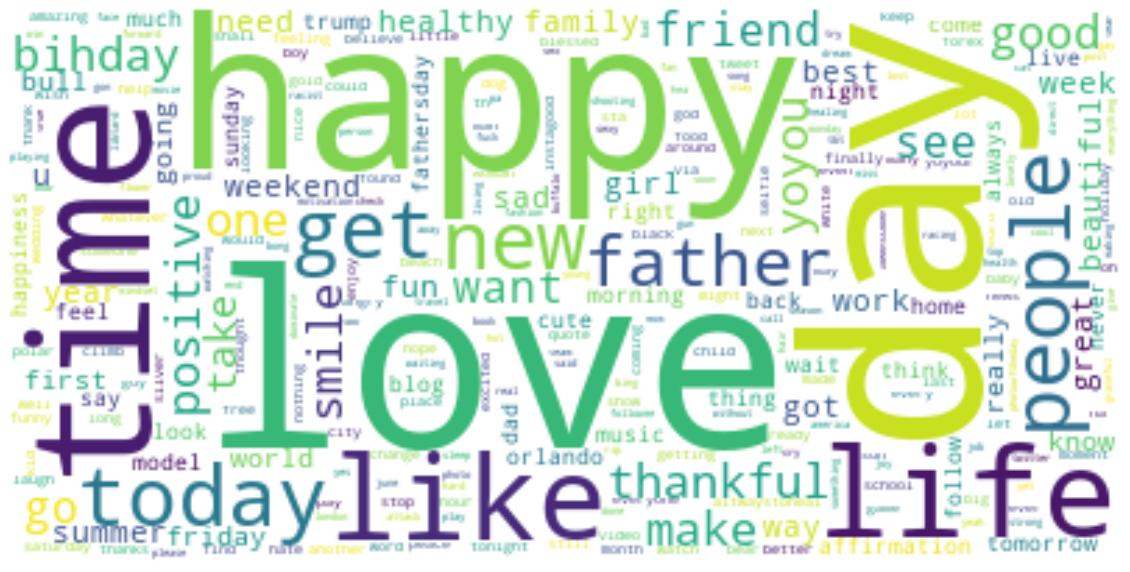

In [68]:
# Total words

words = []
for line in data['tweet_lemmatized']: 
    words.extend(line)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(20,18))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

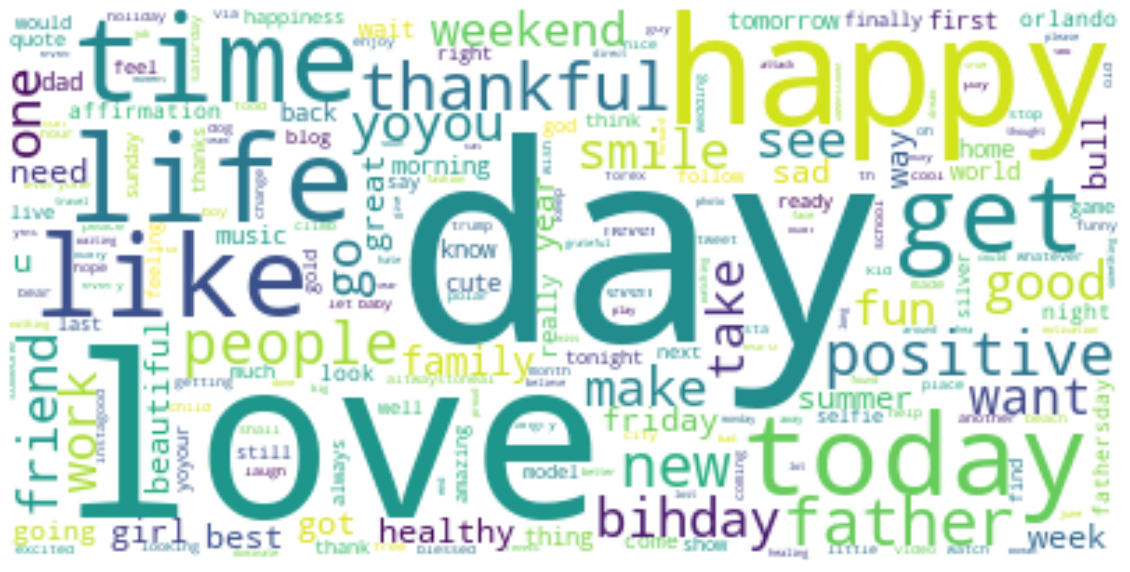

In [69]:
# No toxic comments (combine_df['label'] == 0).
words = []
for line in data[data['label'] == 0]['tweet_lemmatized']: 
    words.extend(line)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(20,18))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

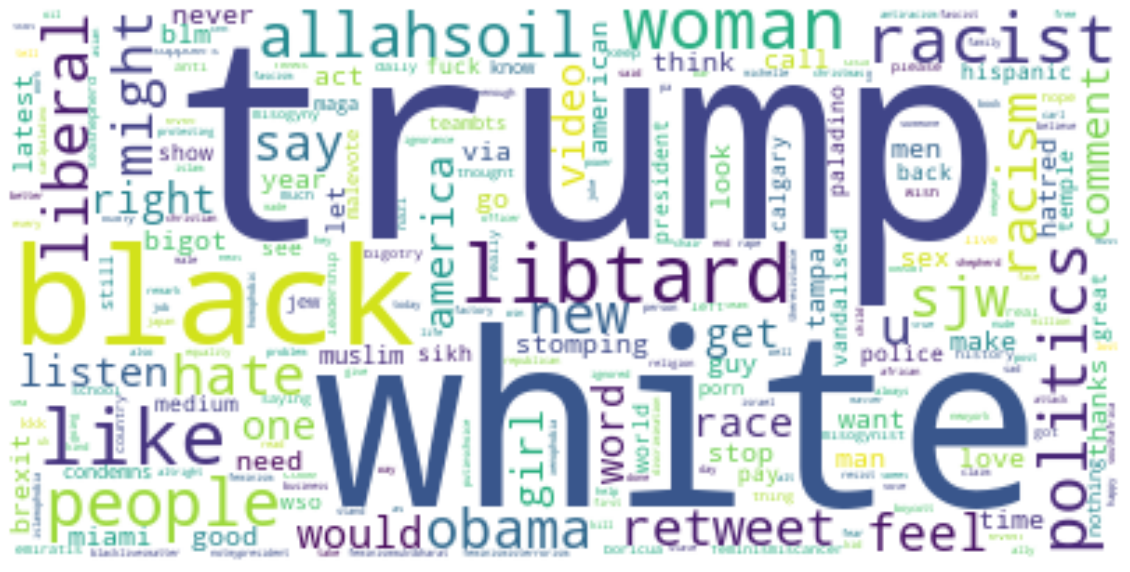

In [70]:
# Toxic comments (combine_df['label'] == 1).
words = []
for line in data[data['label'] == 1]['tweet_lemmatized']: 
    words.extend(line)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(20,18))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()